$need \:to \:add \:labels$

https://www.kaggle.com/datasets/elikplim/forest-fires-data-set

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)

#install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

- Read and wrangle your data.

In [2]:
url <- "https://raw.githubusercontent.com/perdomopatrick/group7/main/forestfires.csv"
data <- read_csv(url)

clean_data <- data|>
      select(-X,-Y,-month,-day)

head(clean_data, n= 5)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0


- Split data into training and test-set.

In [3]:
set.seed(1133) 

data_split <- initial_split(clean_data, prop = 0.75, strata = area)
data_training <- training(data_split)
data_testing <- testing(data_split)

- Make a table or two for the mean statistics of your training set and/or test set.

In [4]:
mean_stats_train <- data_training|>
    summarise(across(everything(), ~mean(.x, na.rm = TRUE)))|>
    pivot_longer(cols = everything(), 
                 names_to = "Variables", 
                 values_to = "Mean")
mean_stats_train

Variables,Mean
<chr>,<dbl>
FFMC,90.6772021
DMC,109.9064767
DC,541.4875648
ISI,9.0487047
temp,18.9655440
RH,44.1502591
wind,4.0261658
rain,0.0253886
area,14.1083161


- Use the forward selection method to choose the best predictor variables for your response. (Check 6.8.3 for the forward selection method)
- https://datasciencebook.ca/classification2.html#forward-selection-in-r

In [5]:
set.seed(1133) 
#install.packages("kknn")

names <- colnames(data_training |> select(-area))

results <- tibble(size = integer(), 
                     model_string = character(), 
                     RMSE = numeric())

# create a model specification for regression KNN
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

# create a 5-fold cross-validation object
fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
  # for every predictor still not added yet
  rmses <- list()
  models <- list()
  for (j in 1:length(names)) {
    # create a model string for this combination of predictors
    preds_new <- c(selected, names[[j]])
    model_string <- paste("area", "~", paste(preds_new, collapse="+"))

    # create a recipe from the model string
    fire_recipe <- recipe(as.formula(model_string), 
                            data = data_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

    # tune the KNN regressor with these predictors, 
    # and collect the RMSE for the best K
    rmse <- workflow() |>
      add_recipe(fire_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fire_vfold, grid = 10) |>
      collect_metrics() |>
      filter(.metric == "rmse") |>
      summarize(mx = min(mean))
    rmse <- rmse$mx |> unlist()

    # add this result to the dataframe
    rmses[[j]] <- rmse
    models[[j]] <- model_string
  }
  jstar <- which.min(unlist(rmses))
  results <- results |> 
    add_row(size = i, 
            model_string = models[[jstar]], 
            RMSE = rmses[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}
results

! Fold1: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold2: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold3: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warni

size,model_string,RMSE
<int>,<chr>,<dbl>
1,area ~ RH,60.67079
2,area ~ RH+rain,60.69569
3,area ~ RH+rain+DMC,64.84574
4,area ~ RH+rain+DMC+wind,64.64394
5,area ~ RH+rain+DMC+wind+ISI,63.80702
6,area ~ RH+rain+DMC+wind+ISI+DC,64.38295
7,area ~ RH+rain+DMC+wind+ISI+DC+FFMC,64.91035
8,area ~ RH+rain+DMC+wind+ISI+DC+FFMC+temp,66.77548


- Display the distributions of each of these variables using histograms (Hint: use facet_wrap() or facet_grid() to get all the plots to show together)- 


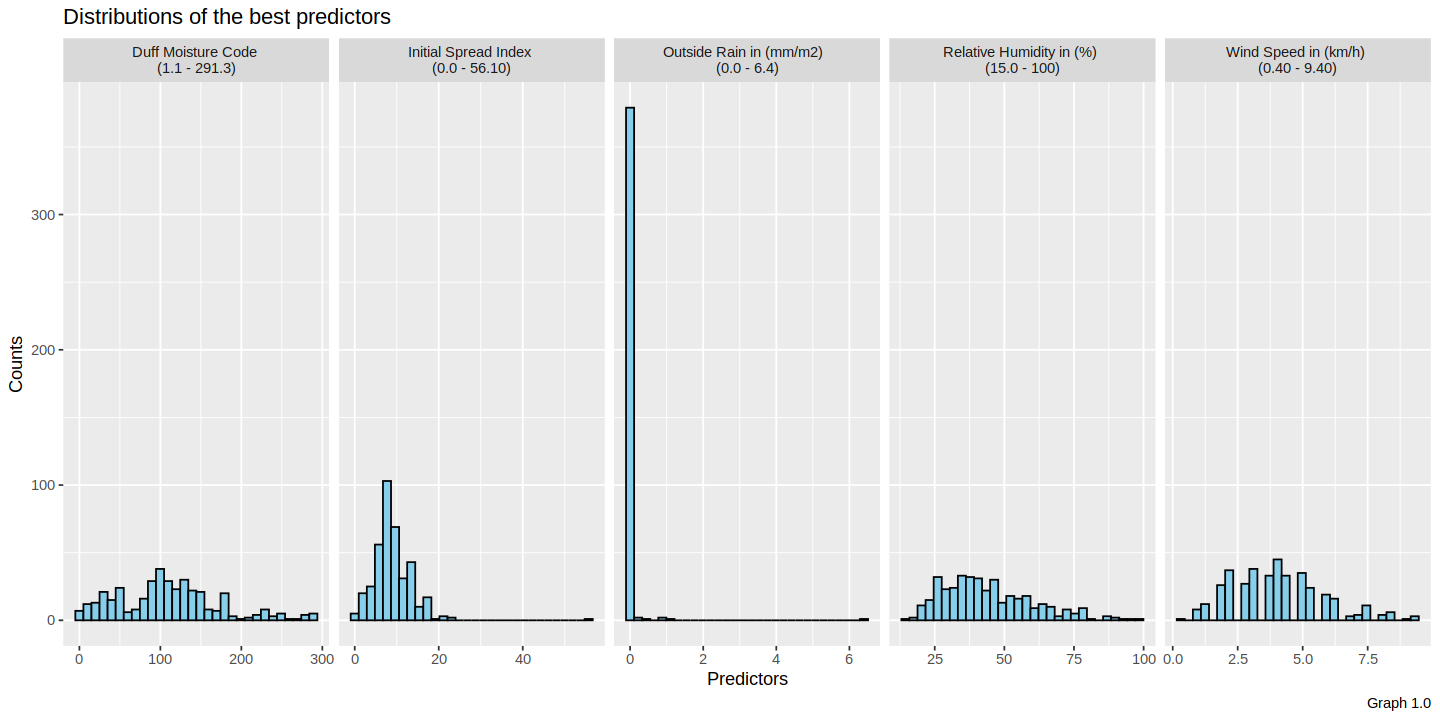

In [6]:

options(repr.plot.width = 12, repr.plot.height = 6)

melted_data <- data_training |>
    select(-FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(RH = "Relative Humidity in (%) \n(15.0 - 100)",
                   rain = "Outside Rain in (mm/m2)  \n(0.0 - 6.4)",
                     DMC="Duff Moisture Code \n(1.1 - 291.3)",
                     wind="Wind Speed in (km/h) \n(0.40 - 9.40)",
                     ISI="Initial Spread Index \n(0.0 - 56.10)")

distribution_plot <- melted_data |>
    ggplot(aes(x = values)) + 
    geom_histogram(position = 'identity', bins = 30,fill = "skyblue", color = "black") +
    labs(x = "Predictors",
         y = "Counts",
         title = "Distributions of the best predictors",
         caption = "Graph 1.0") +
    facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels))

distribution_plot

Visualization of the predictors vs Area

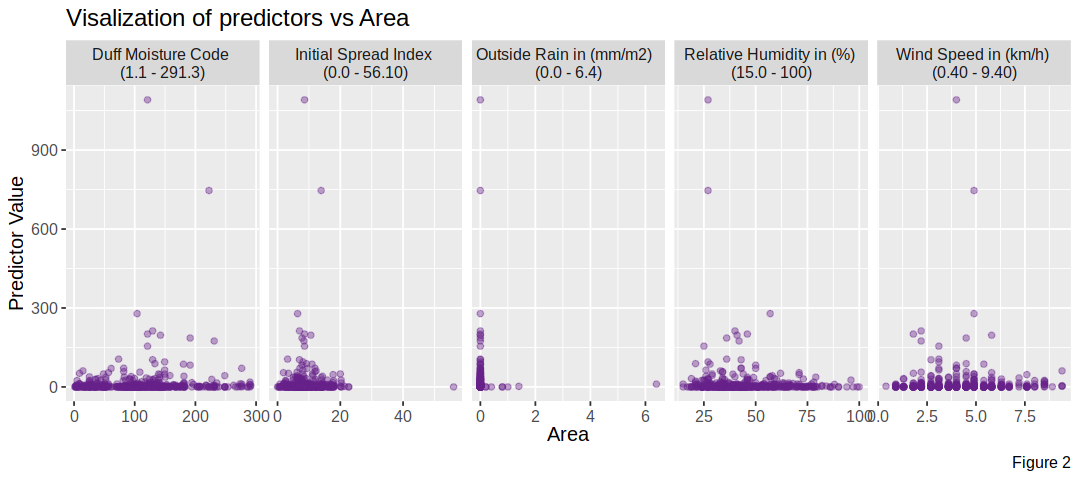

In [7]:
# all the data without the irrelevant columns pivoted longer to be used by facet_grid()
long_data <- data |>
    select(-X, -Y, -month, -day, -FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

options(repr.plot.width = 9, repr.plot.height = 4)

# Initial graph before predictions
initial_plot <- ggplot(long_data, aes(x = values, y = area)) +
  geom_point(alpha = 0.4, color = "darkorchid4") +
  xlab("Area") +
  ylab("Predictor Value") +
 facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
  ggtitle(paste0("Visalization of predictors vs Area")) + 
  theme(text = element_text(size = 12)) +
  labs(caption = "Figure 2")

initial_plot

Tune your model to choose the best k-neighbours using cross validation.

In [8]:
set.seed(1133) 

# recipe with all predictors
fire_recipe <- recipe(area ~ RH + rain + DMC + wind + ISI, data = data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# model for tuning
fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                  set_engine("kknn") |>
                  set_mode("regression")

fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# creates workflow from recipe + model
fire_wkflw <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(fire_spec)

gridvals <- tibble(neighbors = seq(280, 302))

# Filters for rmse
fire_results <- fire_wkflw |>
  tune_grid(resamples = fire_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

# Gets mean
fire_min <- fire_results |>
  filter(mean == min(mean))

fire_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
302,rmse,standard,50.96594,5,25.53731,Preprocessor1_Model23


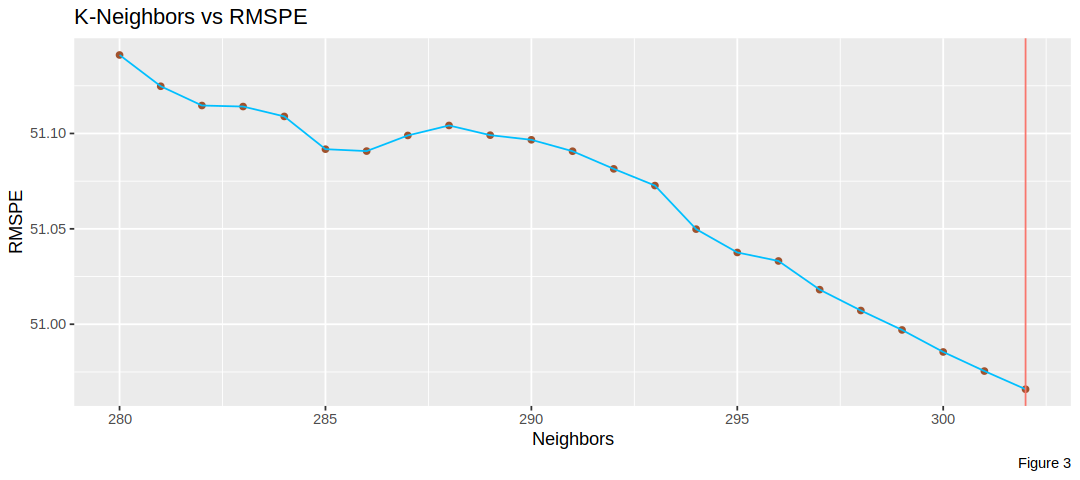

In [9]:
# Visualization of best neighbors
fire_neighbors <- fire_results |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point(colour = "sienna") +
  geom_line(colour = "deepskyblue") +
  geom_vline(aes(xintercept = fire_min$neighbors, colour = "red")) + # takes the neighbors value from min object
  labs(x = "Neighbors", y = "RMSPE", caption = "Figure 3", title ="K-Neighbors vs RMSPE") +
  theme(legend.position="none")

fire_neighbors

Now perform the knn-regression on your test set.

In [10]:
# gets minimum k
kmin <- fire_min |> pull(neighbors)


# create model
new_fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

# create workflow
new_fire_fit <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(new_fire_spec) |>
  fit(data = data_training)

# gets new rmse estimate
new_fire_results <- new_fire_fit |>
  predict(data_testing) |>
  bind_cols(data_testing) |>
  metrics(truth = area, estimate = .pred) |>
  filter(.metric == 'rmse')

new_fire_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,25.74445


Visualization of the model predictions

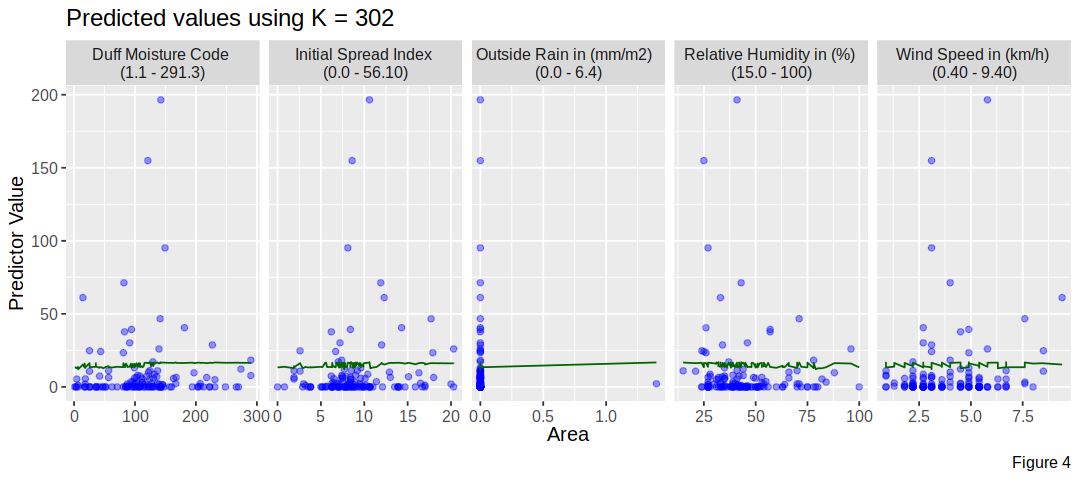

In [11]:
# makes predictions using workflow
fire_preds <- new_fire_fit |>
  predict(data_testing) |>
  bind_cols(data_testing)

# converts data into form usable by facet_grid()
converted_data <- data_testing |>
    select(-FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

# converts predicted data into form usable by the geom_line in facet_grid()
converted_pred_data <- fire_preds |>
    select(-FFMC, -DC, -temp) |> 
    pivot_longer(cols = (c(-area, -.pred)),
                 names_to = "predictors",
                 values_to = "values")

# graphs the predicted value by the actual values
plot <- ggplot(converted_data, aes(x = values, y = area)) +
  geom_point(alpha = 0.4, color = "blue") +
  xlab("Area") +
  ylab("Predictor Value") +
 facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
 geom_line(data = converted_pred_data, 
            mapping = aes(x = values, y = .pred), 
            color = "darkgreen") +
  ggtitle(paste0("Predicted values using K = ", kmin)) + 
  theme(text = element_text(size = 12)) +
  labs(caption = "Figure 4")

plot